In [3]:
from __future__ import annotations

import json
import sys
from dataclasses import asdict, dataclass
from datetime import UTC, datetime
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import torch

from src.utils.models import BuckConverterCell
from src.utils.plot_data import plot_iLvC, plot_u_vs_iL_vC


def find_repo_root(start: Path) -> Path:
    """pyproject.toml を目印にリポジトリルートを探す。"""
    for p in (start, *start.parents):
        if (p / "pyproject.toml").exists() and (p / "src").exists():
            return p
    raise FileNotFoundError(
        "pyproject.toml が見つからず、リポジトリルートを特定できません"
    )


repo_root = find_repo_root(Path.cwd())
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


@dataclass(frozen=True)
class SimConfig:
    # 回路パラメータ（真値としてシミュレーションに使用）
    L: float = 200e-6
    C: float = 48e-6
    R: float = 10.0

    # 入力条件
    Vin: float = 20.0
    Vref: float = 12.0
    f_sw: float = 100_000.0

    # サンプリング条件
    samples_per_cycle: int = 200
    cycles: int = 1000

    # 保存先
    dataset_name: str = "buck_sim"

    @property
    def T(self) -> float:
        return 1.0 / float(self.f_sw)

    @property
    def duty(self) -> float:
        return float(self.Vref) / float(self.Vin)


def simulate_buck(cfg: SimConfig) -> tuple[np.ndarray, np.ndarray]:
    t = np.linspace(
        0,
        cfg.cycles * cfg.T,
        cfg.cycles * cfg.samples_per_cycle + 1,
    )
    dt = np.diff(t)

    # スイッチング信号
    duty_phase = (t[:-1] % cfg.T) / cfg.T
    u = (duty_phase < cfg.duty).astype(int)

    # 入力電圧
    vs = np.ones(len(t) - 1) * cfg.Vin

    x = torch.tensor(np.c_[vs, u, dt], dtype=torch.float32)

    cell = BuckConverterCell(
        L_init=cfg.L,
        C_init=cfg.C,
        R_init=cfg.R,
    )

    iL_list: list[float] = []
    vC_list: list[float] = []

    with torch.no_grad():
        h = torch.tensor([[0, 0]], dtype=torch.float32)
        iL_list.append(float(h[0, 0].item()))
        vC_list.append(float(h[0, 1].item()))

        for k in range(x.shape[0]):
            h = cell(h, x[k : k + 1])
            iL_list.append(float(h[0, 0].item()))
            vC_list.append(float(h[0, 1].item()))

    return (
        t,
        np.asarray(iL_list, dtype=np.float64),
        np.asarray(vC_list, dtype=np.float64),
    )


def save_simulation_dataset(
    *,
    cfg: SimConfig,
    out_dir: Path,
    dataset_name: str,
) -> tuple[Path, Path]:
    """data/<dataset>/<dataset>.csv と <dataset>.json を保存する。"""
    out_dir.mkdir(parents=True, exist_ok=True)
    t, iL, vC = simulate_buck(cfg)

    df = pd.DataFrame({"t": t, "iL": iL, "vC": vC})

    dataset_base = out_dir / dataset_name
    csv_path = dataset_base.with_suffix(".csv")
    json_path = dataset_base.with_suffix(".json")

    df.to_csv(csv_path, index=False)

    meta: dict[str, Any] = {
        "generator": "actual_machine_notebooks/utils/create_csv_data.ipynb",
        "created_at": datetime.now(UTC).isoformat(),
        "model": "BuckConverterCell",
        "config": asdict(cfg) | {"T": cfg.T, "duty": cfg.duty},
        "n_steps": int(df.shape[0]),
        "columns": list(df.columns),
        "units": {
            "t": "s",
            "t_next": "s",
            "dt": "s",
            "vs": "V",
            "u": "-",
            "iL": "A",
            "vC": "V",
            "iL_next": "A",
            "vC_next": "V",
        },
    }

    json_path.write_text(
        json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8"
    )
    return csv_path, json_path


# =========================
# 実行（ここを必要に応じて変更）
# =========================
cfg = SimConfig(
    L=223.6e-6,
    C=73.8e-6,
    R=5.0,
    Vin=10.0,
    Vref=5.0,
    f_sw=1e5,
    samples_per_cycle=2000,
    cycles=1000,
)
dataset_name = (
    f"buck_sim_Vin{cfg.Vin}_Vref{cfg.Vref}_fs{cfg.f_sw}_ppc{cfg.samples_per_cycle}_cyc{cfg.cycles}",
)[0]

torch.manual_seed(0)

save_root = repo_root / "data" / dataset_name
csv_path, json_path = save_simulation_dataset(
    cfg=cfg, out_dir=save_root, dataset_name=dataset_name
)

# プロジェクトルートからの相対パスで表示
print(f"saved: {csv_path.relative_to(repo_root)}")
print(f"saved: {json_path.relative_to(repo_root)}")


saved: data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc2000_cyc1000/buck_sim_Vin10.0_Vref5.0_fs100000.csv
saved: data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc2000_cyc1000/buck_sim_Vin10.0_Vref5.0_fs100000.json


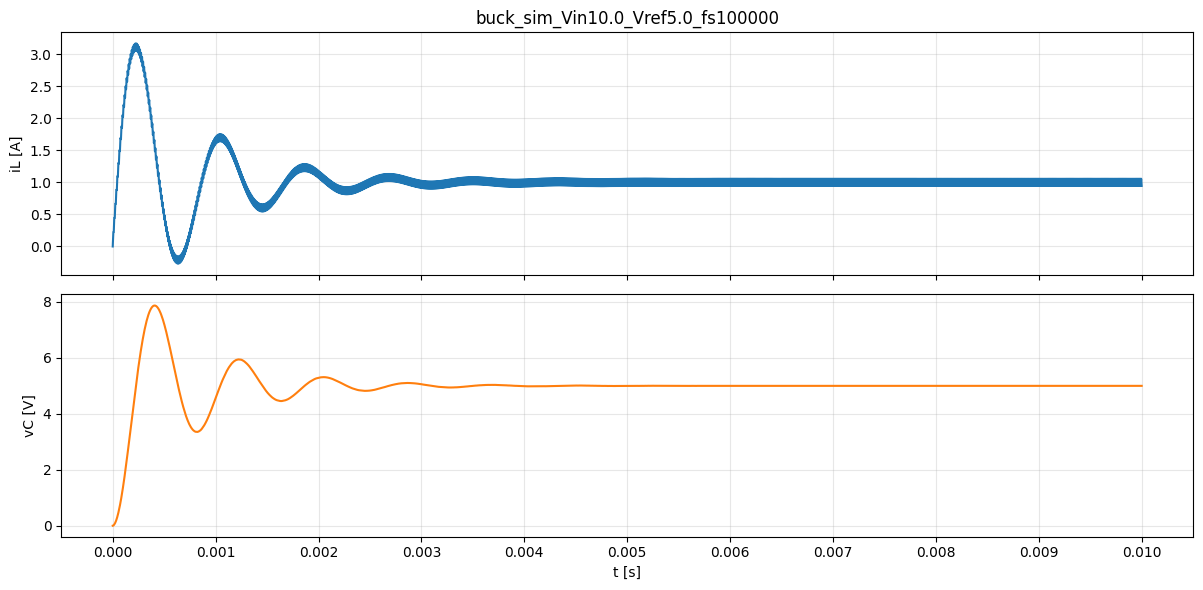

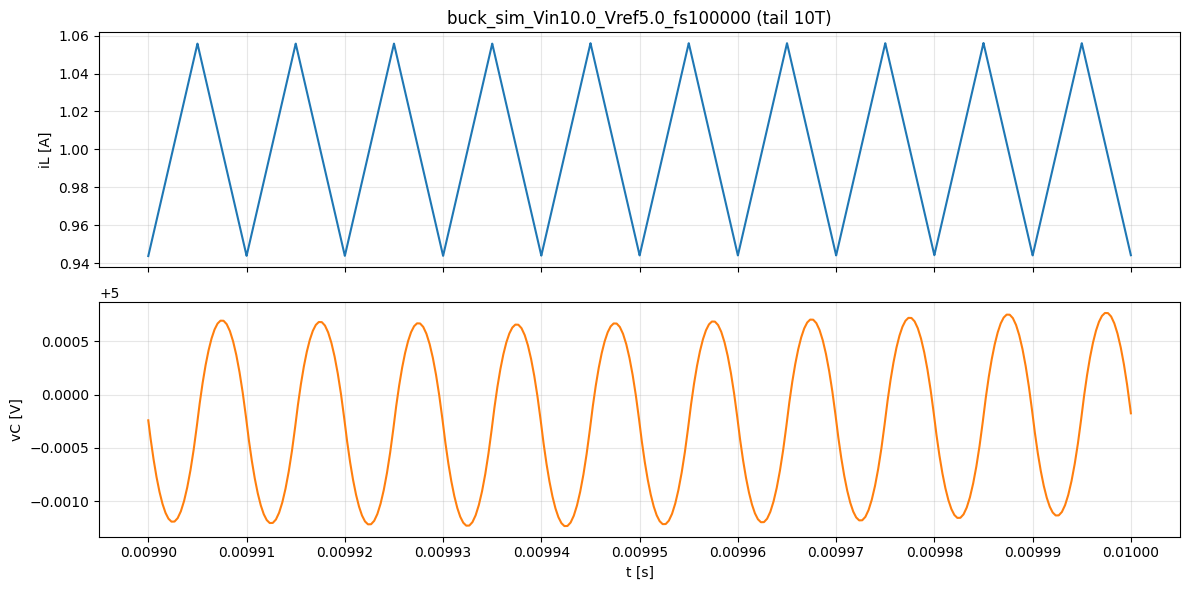

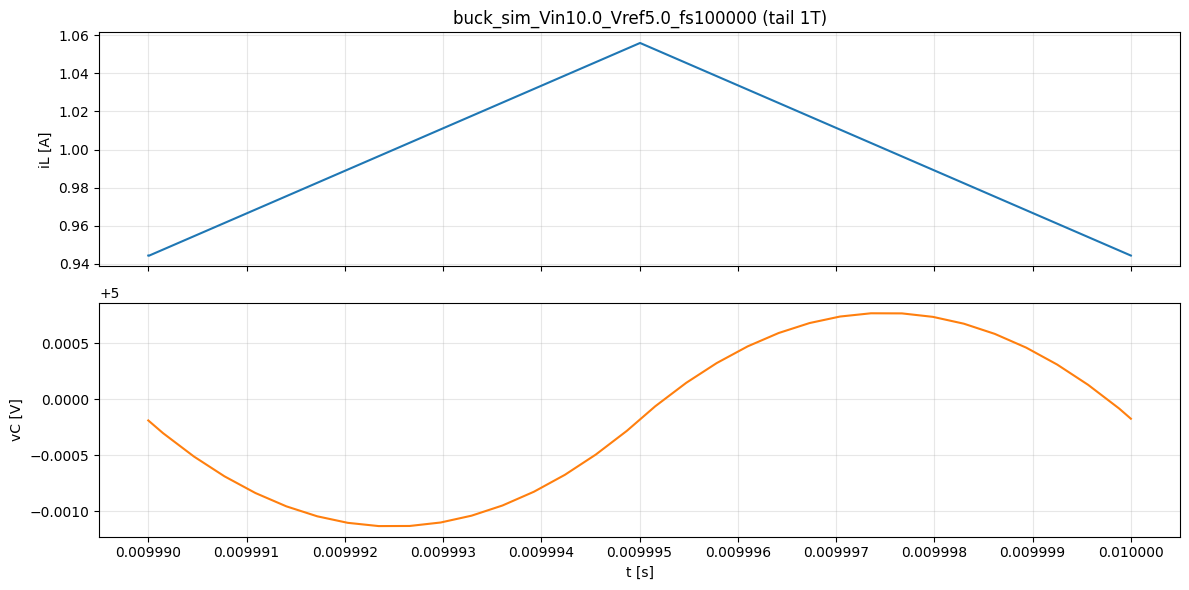

In [4]:
csv_file = Path(str(csv_path))
df = pd.read_csv(csv_file)

t = df["t"].to_numpy(dtype=np.float64)
iL = df["iL"].to_numpy(dtype=np.float64)
vC = df["vC"].to_numpy(dtype=np.float64)

fig_list = plot_iLvC(
    t=t,
    iL=iL,
    vC=vC,
    T=cfg.T,
    title=csv_file.stem,
)